In [ ]:
import noisereduce as nr
import librosa
import numpy as np

# Načtení zvuku (původního mixu)
y, sr = librosa.load("birdsong.wav", sr=None)

# Automatické získání šumového profilu (noisereduce používá první část nahrávky)
noise_segment = y[:int(sr * 0.5)]  # Prvních 0.5 sekundy

# Vypočítání spektra šumu (co Noisereduce považuje za šum)
noise_profile = np.mean(librosa.stft(noise_segment), axis=1)  # Průměr přes časové snímky

# Funkce pro výpočet SNR
def calculate_snr(signal, noise_spectrum):
    """
    Vypočítá SNR na základě spektrálního profilu šumu.
    """
    signal_spectrum = np.mean(librosa.stft(signal), axis=1)
    
    # Energie signálu a šumu
    signal_power = np.mean(signal_spectrum ** 2)
    noise_power = np.mean(noise_spectrum ** 2)

    # Ochrana proti dělení nulou
    noise_power = max(noise_power, 1e-10)

    # SNR v dB
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

# Výpočet SNR pro každý separovaný kanál
snr_values = []
for i in range(separated_signals.shape[1]):
    separated_signal_mono = separated_signals[:, i]
    snr_db = calculate_snr(separated_signal_mono, noise_profile)
    snr_values.append((i, snr_db))

# Seřazení kanálů podle SNR (od nejvyšší po nejnižší)
sorted_snr_values = sorted(snr_values, key=lambda x: x[1], reverse=True)

# Výpis výsledků
for channel, snr in sorted_snr_values:
    print(f"Channel {channel}: SNR = {snr:.2f} dB")


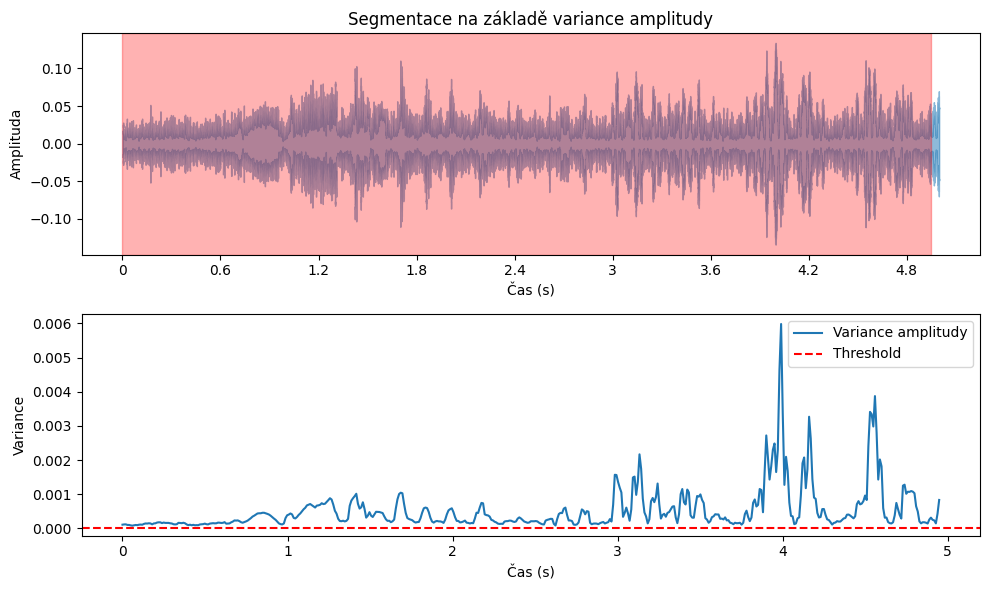

Detekované segmenty (začátek, konec) v sekundách:
0.00 s - 4.95 s


In [2]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def compute_variance(audio, sr, window_size=0.05, hop_size=0.01, threshold=1e-5):
    """
    Vypočítá varianci amplitudy v klouzavém okně a detekuje segmenty nad prahem.
    
    Parametry:
    - audio: vstupní audio signál (numpy array)
    - sr: vzorkovací frekvence (např. 22050 Hz)
    - window_size: velikost okna v sekundách (např. 50 ms)
    - hop_size: krok posunu okna v sekundách (např. 10 ms)
    - threshold: práh variance pro segmentaci
    
    Výstup:
    - segment_times: seznam segmentů (začátek, konec) v sekundách
    - variance_values: vypočítané hodnoty variance pro každý segment
    - times: časové okamžiky odpovídající variance_values
    """
    
    # Převod velikosti okna a kroku na vzorky
    window_samples = int(window_size * sr)
    hop_samples = int(hop_size * sr)
    
    variance_values = []
    times = []
    
    for start in range(0, len(audio) - window_samples, hop_samples):
        window = audio[start:start + window_samples]
        var = np.var(window)  # Výpočet variance amplitudy
        variance_values.append(var)
        times.append(start / sr)  # Převod na sekundy
    
    # Detekce segmentů nad prahem
    segment_times = []
    in_segment = False
    segment_start = 0

    for i, var in enumerate(variance_values):
        if var > threshold:
            if not in_segment:
                segment_start = times[i]
                in_segment = True
        else:
            if in_segment:
                segment_times.append((segment_start, times[i]))
                in_segment = False

    # Přidání posledního segmentu, pokud skončil na konci signálu
    if in_segment:
        segment_times.append((segment_start, times[-1]))

    return segment_times, variance_values, times

# Načtení audia (například ptačí zpěv)
file_path = "/Users/vojtechremis/Downloads/Example_5_(amepip,_gcrfin,_whcspa)_mix.wav"  # Nahraď svým souborem
audio, sr = librosa.load(file_path, sr=None)  # Načtení při původním sr

# Spočítání variance a detekce segmentů
segment_times, variance_values, times = compute_variance(audio, sr)

# Vykreslení výsledků
plt.figure(figsize=(10, 6))

# Zobrazení waveformu
plt.subplot(2, 1, 1)
librosa.display.waveshow(audio, sr=sr, alpha=0.5)
for start, end in segment_times:
    plt.axvspan(start, end, color='red', alpha=0.3)  # Zvýraznění detekovaných segmentů
plt.title("Segmentace na základě variance amplitudy")
plt.xlabel("Čas (s)")
plt.ylabel("Amplituda")

# Vykreslení variance
plt.subplot(2, 1, 2)
plt.plot(times, variance_values, label="Variance amplitudy")
plt.axhline(y=1e-5, color='r', linestyle='--', label="Threshold")
plt.xlabel("Čas (s)")
plt.ylabel("Variance")
plt.legend()

plt.tight_layout()
plt.show()

# Výpis detekovaných segmentů
print("Detekované segmenty (začátek, konec) v sekundách:")
for start, end in segment_times:
    print(f"{start:.2f} s - {end:.2f} s")


In [ ]:
def ThreeStageVarianceThresholding(y, sr, hop_size, window_size1=0.2, window_size2=0.15, window_size3=0.05,
                                   k1=0.5, k2=0.3, k3=0.2, merge_distance=1e3):
    """
    Aplikuje tříúrovňový variance thresholding na signál y.
    """
    print("sr", sr)
    window_samples1 = int(window_size1 * sr)
    window_samples2 = int(window_size2 * sr)
    window_samples3 = int(window_size3 * sr)
    hop_samples = int(hop_size * sr)

    if len(y) < window_samples1:
        raise ValueError(
            "Audio signal is too short for the given window_size. Increase hop_size or reduce window_size.")

    variance_values = []
    times_variance = []

    for start in range(0, len(y) - window_samples1, hop_samples):
        window = y[start:start + window_samples1]
        var = np.var(window)
        variance_values.append(var)
        times_variance.append(start / sr)

    variance_values = np.array(variance_values, dtype=np.float32)

    # 1. Jisté segmenty (pevnější práh)
    strong_threshold = sauvola_thresholding(variance_values, window_size=150, k=k1)

    # 2. Možné segmenty (slabší práh)
    weak_threshold = sauvola_thresholding(variance_values, window_size=100, k=k2)

    strong_segments = []
    weak_segments = []
    in_strong_segment = False
    in_weak_segment = False
    segment_start = 0

    for i, (var, strong_thresh, weak_thresh) in enumerate(zip(variance_values, strong_threshold, weak_threshold)):
        if var > strong_thresh:
            if not in_strong_segment:
                segment_start = times_variance[i]
                in_strong_segment = True
            in_weak_segment = False
        elif var > weak_thresh:
            if not in_weak_segment:
                segment_start = times_variance[i]
                in_weak_segment = True
        else:
            if in_strong_segment:
                strong_segments.append((segment_start, times_variance[i]))
                in_strong_segment = False
            elif in_weak_segment:
                weak_segments.append((segment_start, times_variance[i]))
                in_weak_segment = False

    if in_strong_segment:
        strong_segments.append((segment_start, times_variance[-1]))
    if in_weak_segment:
        weak_segments.append((segment_start, times_variance[-1]))

    # 3. Spojení segmentů – pokud se slabý segment **dotýká** silného (méně než merge_distance)
    merged_segments = strong_segments[:]
    for weak_start, weak_end in weak_segments:
        for i, (strong_start, strong_end) in enumerate(merged_segments):
            if abs(weak_start - strong_end) < merge_distance or abs(weak_end - strong_start) < merge_distance:
                merged_segments[i] = (min(strong_start, weak_start), max(strong_end, weak_end))
                break
        else:
            merged_segments.append((weak_start, weak_end))

    # 4. Jemná podsegmentace uvnitř segmentů + vykreslení STFT
    final_segments = []
    tiny_threshold_values = np.zeros_like(variance_values)

    print("merged_segments", merged_segments)
    print("times_variance.shape", len(times_variance))

    for idx, (start, end) in enumerate(merged_segments):
        segment_mask = (np.array(times_variance) >= start) & (np.array(times_variance) <= end)
        segment_variance = variance_values[segment_mask]

        print("segment_variance.shape", segment_variance.shape)

        print(f"Post-segmenting segment with bin_length={len(segment_variance)}, sauvola window_size={50}")
        local_threshold = sauvola_thresholding(segment_variance, window_size=50, k=k3)
        tiny_threshold_values[segment_mask] = local_threshold  # Uložíme pro vizualizaci

        sub_segments = []
        sub_start = None

        for i, (var, thresh) in enumerate(zip(segment_variance, local_threshold)):
            if var > thresh:
                if sub_start is None:
                    sub_start = times_variance[np.where(segment_mask)[0][i]]
            else:
                if sub_start is not None:
                    sub_segments.append((sub_start, times_variance[np.where(segment_mask)[0][i]]))
                    sub_start = None

        if sub_start is not None:
            sub_segments.append((sub_start, end))

        # Zachováme původní začátek a konec segmentu
        if sub_segments:
            if sub_segments[0][0] > start:
                sub_segments.insert(0, (start, sub_segments[0][0]))  # Přidáme původní začátek
            if sub_segments[-1][1] < end:
                sub_segments.append((sub_segments[-1][1], end))  # Přidáme původní konec

        final_segments.extend(sub_segments)

        # **PLT: Vykreslení STFT pro tento segment**
        segment_start_sample = int(start * sr)
        segment_end_sample = int(end * sr)
        segment_audio = y[segment_start_sample:segment_end_sample]

        fig, ax = plt.subplots(figsize=(10, 5))

        # Výpočet spektrogramu (time_bins = časová osa, frequency_bins = frekvence, spectrum = energie)
        time_bins, frequency_bins, spectrum = calculate_spectrogram(segment_audio, sr)

        # Převod na dB
        spectrum_db = 10 * np.log10(np.maximum(spectrum, 1e-10))  # Bezpečný log10, aby se předešlo log(0)

        # Vykreslení spektra pomocí pcolormesh()
        cmap = ax.pcolormesh(time_bins, frequency_bins, spectrum, cmap='gray', shading='auto')

        # Přidání barevné škály
        fig.colorbar(cmap, ax=ax, label="Intensity [dB]")

        # Nastavení os
        ax.set_xlabel("Time [s]")
        ax.set_ylabel("Frequency [Hz]")
        plt.title(f"Segment {idx + 1} ({start:.2f}s - {end:.2f}s)")

        # 📌 Sekundární osa (Variance)
        # Overlay variance a threshold v čase
        segment_time_axis = np.array(times_variance)[segment_mask]

        ax_secondary = ax.twinx()
        ax_secondary.plot(segment_time_axis - start, segment_variance, label="Variance", color='green', linewidth=1)
        ax_secondary.plot(segment_time_axis - start, local_threshold, label="Threshold", color='red', linewidth=1)

        ax_secondary.set_ylabel("Variance")
        ax_secondary.spines['right'].set_color('green')  # Zvýraznění sekundární osy

        # 📊 Přidání legendy pro varianci
        ax_secondary.legend(loc="upper right")

        # # Správné nastavení poměru stran bez deformace osy X
        ax.set_box_aspect(10)  # Toto upraví pouze velikost samotného grafu, ne celé figure

        ax.set_anchor('C')  # Zajistí, že graf zůstane ve středu
        ax_secondary.set_anchor('C')  # Zajistí, že graf zůstane ve středu

        plt.legend(loc="upper right", bbox_to_anchor=(1.5, 1))

        plt.legend()
        plt.show()

    # Časová interpolace pro vizualizaci
    variance_full = np.interp(np.arange(len(y)) / sr, times_variance, variance_values)
    threshold_full = np.interp(np.arange(len(y)) / sr, times_variance, strong_threshold)
    threshold_full_weak = np.interp(np.arange(len(y)) / sr, times_variance, weak_threshold)
    threshold_full_tiny = np.interp(np.arange(len(y)) / sr, times_variance, tiny_threshold_values)

    return final_segments, variance_full, threshold_full, threshold_full_weak, threshold_full_tiny
